In [ ]:
# Create a stock price predictor - using the ‘yfinance’ library as data source - for MSFT’s share price (Microsoft). 
# The tool will be measured on its prediction accuracy (the test set should comprise of data post 2018). 
# Also, which other U.S. tech stock is MSFT most correlated to?

In [ ]:
# The problem is to predict the stock price of msft shares given the data of the older days.

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import statements

In [ ]:
import yfinance as yf
import math
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
warnings.filterwarnings("ignore")

# Data download

In [ ]:
# 13 years of data for model training 
train_df = yf.download('MSFT',start='2005-01-01',end='2017-12-31',progress=False)
train_df.shape

(3272, 6)

In [ ]:
#3 years of data for testing and validation on unseen data.
test_df = yf.download('MSFT',start='2018-01-01',end='2020-12-31',progress=False)
test_df.shape

(755, 6)

# Data exploration and checking for missing values

In [ ]:
# Explore the given dataset by looking at the initial few instances. There are 6 cols namely Open,high,low,close,adj close,volume. 
# Volume -  Tells us the total number of shares of msft that were bought or sold on that particular day
train_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,26.799999,26.950001,26.650000,26.740000,18.913971,65002900
2005-01-04,26.870001,27.100000,26.660000,26.840000,18.984703,109442100
2005-01-05,26.840000,27.100000,26.760000,26.780001,18.942266,72463500
2005-01-06,26.850000,27.059999,26.639999,26.750000,18.921051,76890500
2005-01-07,26.820000,26.889999,26.620001,26.670000,18.864464,68723300


In [ ]:
# we also see that all columns except volume have the float datatype whereas volume is int. 
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3272 entries, 2005-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3272 non-null   float64
 1   High       3272 non-null   float64
 2   Low        3272 non-null   float64
 3   Close      3272 non-null   float64
 4   Adj Close  3272 non-null   float64
 5   Volume     3272 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 178.9 KB


In [ ]:
train_df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
# we use the describe method to see the range of values that go for each col.
train_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3272.000000,3272.000000,3272.000000,3272.000000,3272.000000,3.272000e+03
mean,35.677124,35.997170,35.366653,35.691715,29.687203,5.276291e+07
std,14.389426,14.451545,14.319908,14.400468,14.937945,3.067761e+07
min,15.200000,15.620000,14.870000,15.150000,11.437002,7.425600e+06
25%,26.207500,26.487500,25.957500,26.207500,19.731844,3.257308e+07
50%,29.485000,29.740000,29.170000,29.469999,22.570160,4.791400e+07
75%,42.955001,43.242501,42.612499,43.062501,37.728510,6.471538e+07
max,87.120003,87.500000,86.230003,86.849998,82.018440,5.910522e+08


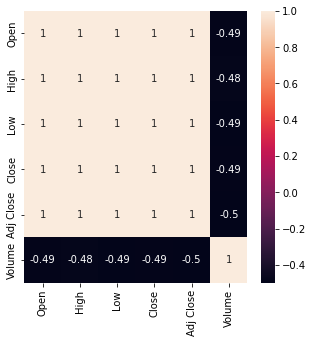

In [ ]:
cormap = train_df.corr()
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cormap, annot = True)

All features except volume are highly co-related. Thus, using only one of them - Open price for predictions

# Data visualisation



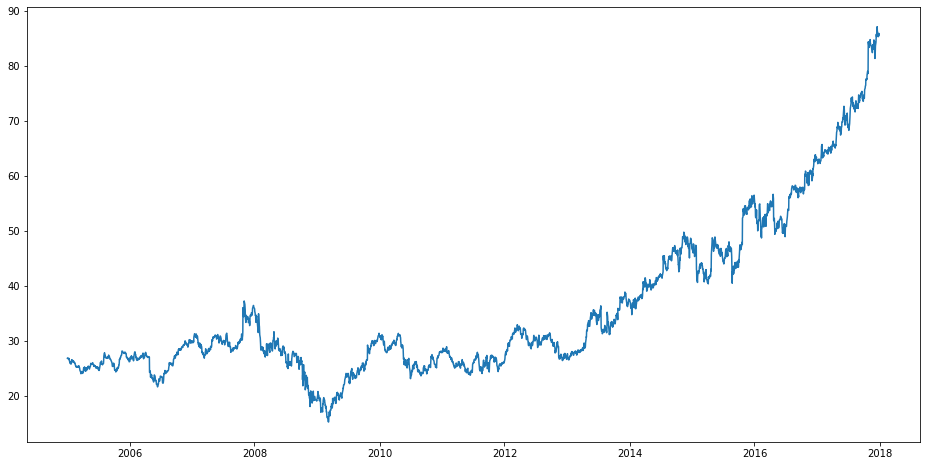

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(train_df["Open"],label='Open Price history')

# Data normalisation

In [ ]:
from sklearn.preprocessing import MinMaxScaler

train_df = train_df.iloc[:,0:1]
sc = MinMaxScaler(feature_range = (0,1))
training_scaled = sc.fit_transform(train_df)
training_scaled

array([[0.16129031],
       [0.16226363],
       [0.16184649],
       ...,
       [0.97956061],
       [0.98303669],
       [0.97928246]])

In [ ]:

X = []
y = []
for i in range(60,len(train_df)):
    X.append(training_scaled[i-60:i, 0])
    y.append(training_scaled[i,0])
X,y = np.array(X),np.array(y)
X.shape,y.shape

((3212, 60), (3212,))

In [ ]:
from sklearn.model_selection import train_test_split
res = pd.DataFrame(columns = ['model','mse','rmse'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)
X_train.shape,y_train.shape

((2569, 60), (2569,))

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

model1 = xgb.XGBRegressor()
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)


mse = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
res = res.append({'model':'XGBoost','mse':mse,'rmse':rmse, 'mae':mae,'r2':r2},ignore_index=True)

[10:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
from sklearn.linear_model import LinearRegression
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
model2 = LinearRegression()
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
res = res.append({'model':'LinearRegression','mse':mse,'rmse':rmse, 'mae':mae,'r2':r2},ignore_index=True)

In [ ]:
from sklearn.ensemble import BaggingRegressor

model3 = BaggingRegressor(base_estimator=LinearRegression(),n_estimators=20)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
res = res.append({'model':'BaggingRegressor','mse':mse,'rmse':rmse, 'mae':mae,'r2':r2},ignore_index=True)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model4 = RandomForestRegressor(max_depth=20)
model4.fit(X_train, y_train)
y_pred = model4.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
res = res.append({'model':'RandomForestRegressor','mse':mse,'rmse':rmse, 'mae':mae,'r2':r2},ignore_index=True)

In [ ]:
from sklearn.linear_model import Ridge

model5 = Ridge(alpha=0.1)
model5.fit(X_train, y_train)
y_pred = model5.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
res = res.append({'model':'RidgeRegressor','mse':mse,'rmse':rmse, 'mae':mae,'r2':r2},ignore_index=True)

In [ ]:
from sklearn.linear_model import Lasso

model6 = Lasso(alpha=0.1)
model6.fit(X_train, y_train)
y_pred = model6.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
res = res.append({'model':'LassoRegressor','mse':mse,'rmse':rmse, 'mae':mae,'r2':r2},ignore_index=True)

LSTM

In [ ]:
X = np.reshape(X, (X.shape[0],X.shape[1],1))
X.shape

(3212, 60, 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential

model_dl1 = Sequential()
model_dl1.add(LSTM(units = 50,return_sequences = True,input_shape = (X.shape[1],1)))
model_dl1.add(Dropout(0.2))

model_dl1.add(LSTM(units = 50,return_sequences = True))
model_dl1.add(Dropout(0.2))

model_dl1.add(LSTM(units = 50,return_sequences = True))
model_dl1.add(Dropout(0.2))

model_dl1.add(LSTM(units=50))
model_dl1.add(Dropout(0.2))

model_dl1.add(Dense(units=1))

model_dl1.compile(optimizer='adam',loss='mean_squared_error')

print(model_dl1.summary())

model_dl1.fit(X_train,y_train,epochs=20,batch_size=32)
y_pred = model_dl1.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

res = res.append({'model':'LSTM1','mse':mse,'rmse':rmse, 'mae':mae,'r2':r2},ignore_index=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential


model_dl2 = Sequential()
model_dl2.add(LSTM(units = 100,return_sequences = True,input_shape = (X.shape[1],1)))
model_dl2.add(Dropout(0.2))

model_dl2.add(LSTM(units=100))
model_dl2.add(Dropout(0.2))

model_dl2.add(Dense(units=1))

model_dl2.compile(optimizer='adam',loss='mean_squared_error')

print(model_dl2.summary())

model_dl2.fit(X_train,y_train,epochs=20,batch_size=32)
y_pred = model_dl2.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

res = res.append({'model':'LSTM2','mse':mse,'rmse':rmse, 'mae':mae,'r2':r2},ignore_index=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 100)           40800     
                                                                 
 dropout_4 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
81/81 [=========================

In [ ]:
res

,model,mse,rmse,mae,r2
0,XGBoost,0.057938,0.240703,0.188627,-1.430796
1,LinearRegression,0.000115,0.010716,0.007357,0.995182
2,BaggingRegressor,0.000115,0.010729,0.007370,0.995170
3,RandomForestRegressor,0.050023,0.223659,0.170854,-1.098737
4,RidgeRegressor,0.000126,0.011224,0.007793,0.994715
5,LassoRegressor,0.203962,0.451622,0.424414,-7.557281
6,LSTM1,0.001335,0.036533,0.030270,0.944003
7,LSTM2,0.000221,0.014873,0.010655,0.990719


From the results of the training set, 

*   It is clear that Linear regression performs the best out of all. BaggingRegressor is also very close enough when compared followed by RidgeRegressor.

*   The Best model's accuracy and performance can be futher improved by hyperparameter tuning techniques using Gridsearch cv or libraries hyperopt/optuna to find the best parameters.

* Further, K-fold cross validation can be introduced too.


# Results on test set 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

test_df = test_df.iloc[:,0:1]
sc = MinMaxScaler(feature_range = (0,1))
testing_scaled = sc.fit_transform(test_df)
testing_scaled.shape

(755, 1)

In [ ]:
import numpy as np

X = []
y = []
for i in range(60,len(test_df)):
    X.append(testing_scaled[i-60:i, 0])
    y.append(testing_scaled[i,0])
X,y = np.array(X),np.array(y)
X.shape,y.shape

((695, 60), (695,))

In [ ]:
y_pred = model1.predict(X)

mse = mean_squared_error(y,y_pred)
rmse = math.sqrt(mean_squared_error(y,y_pred))
mae = mean_absolute_error(y,y_pred)
r2 = r2_score(y,y_pred)
print(mse,rmse)
res = res.append({'model':'XGBoost_val','mse':mse,'rmse':rmse, 'mae':mae,'r2':r2},ignore_index=True)

0.04250761513817558 0.20617374987659215


In [ ]:
y_pred = model2.predict(X)

mse = mean_squared_error(y,y_pred)
rmse = math.sqrt(mean_squared_error(y,y_pred))
mae = mean_absolute_error(y,y_pred)
r2 = r2_score(y,y_pred)
print(mse,rmse)
res = res.append({'model':'LinearRegression_val','mse':mse,'rmse':rmse, 'mae':mae,'r2':r2},ignore_index=True)

0.00041951105345931696 0.020481968983945782


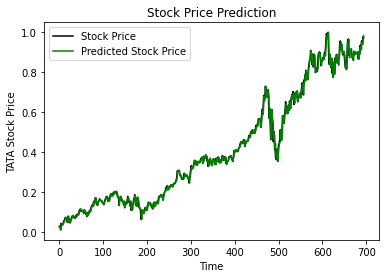

In [ ]:
plt.plot(y, color = 'black', label = 'Stock Price')
plt.plot(y_pred, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()

In [ ]:
y_pred = model3.predict(X)

mse = mean_squared_error(y,y_pred)
rmse = math.sqrt(mean_squared_error(y,y_pred))
mae = mean_absolute_error(y,y_pred)
r2 = r2_score(y,y_pred)
print(mse,rmse)
res = res.append({'model':'BaggingRegressor_val','mse':mse,'rmse':rmse, 'mae':mae,'r2':r2},ignore_index=True)

0.00041998654792387214 0.02049357333223936


In [ ]:
y_pred = model4.predict(X)

mse = mean_squared_error(y,y_pred)
rmse = math.sqrt(mean_squared_error(y,y_pred))
mae = mean_absolute_error(y,y_pred)
r2 = r2_score(y,y_pred)
print(mse,rmse)
res = res.append({'model':'RandomForestRegressor_val','mse':mse,'rmse':rmse, 'mae':mae,'r2':r2},ignore_index=True)

0.0381591081265915 0.1953435643336926


In [ ]:
y_pred = model5.predict(X)

mse = mean_squared_error(y,y_pred)
rmse = math.sqrt(mean_squared_error(y,y_pred))
mae = mean_absolute_error(y,y_pred)
r2 = r2_score(y,y_pred)
print(mse,rmse)
res = res.append({'model':'RidgeRegressor_val','mse':mse,'rmse':rmse, 'mae':mae,'r2':r2},ignore_index=True)

0.0004468514150829809 0.021138860307097468


In [ ]:
y_pred = model6.predict(X)

mse = mean_squared_error(y,y_pred)
rmse = math.sqrt(mean_squared_error(y,y_pred))
mae = mean_absolute_error(y,y_pred)
r2 = r2_score(y,y_pred)
print(mse,rmse)
res = res.append({'model':'LassoRegressor_val','mse':mse,'rmse':rmse, 'mae':mae,'r2':r2},ignore_index=True)

0.12653269974848327 0.3557143513389406


In [ ]:
X = np.reshape(X, (X.shape[0],X.shape[1],1))
X.shape

(695, 60, 1)

In [ ]:
y_pred = model_dl1.predict(X)

mse = mean_squared_error(y,y_pred)
rmse = math.sqrt(mean_squared_error(y,y_pred))
mae = mean_absolute_error(y,y_pred)
r2 = r2_score(y,y_pred)
print(mse,rmse)
res = res.append({'model':'LSTM1_val','mse':mse,'rmse':rmse, 'mae':mae,'r2':r2},ignore_index=True)

0.0019063320892722237 0.04366156306492272


In [ ]:
y_pred = model_dl2.predict(X)

mse = mean_squared_error(y,y_pred)
rmse = math.sqrt(mean_squared_error(y,y_pred))
mae = mean_absolute_error(y,y_pred)
r2 = r2_score(y,y_pred)
print(mse,rmse)
res = res.append({'model':'LSTM2_val','mse':mse,'rmse':rmse, 'mae':mae,'r2':r2},ignore_index=True)

0.0007175484607549394 0.026787095041361605


In [ ]:
res

,model,mse,rmse,mae,r2
0,XGBoost,0.057938,0.240703,0.188627,-1.430796
1,LinearRegression,0.000115,0.010716,0.007357,0.995182
2,BaggingRegressor,0.000115,0.010729,0.007370,0.995170
3,RandomForestRegressor,0.050023,0.223659,0.170854,-1.098737
4,RidgeRegressor,0.000126,0.011224,0.007793,0.994715
5,LassoRegressor,0.203962,0.451622,0.424414,-7.557281
6,LSTM1,0.001335,0.036533,0.030270,0.944003
7,LSTM2,0.000221,0.014873,0.010655,0.990719
8,XGBoost_val,0.042508,0.206174,0.116090,0.471661
9,LinearRegression_val,0.000420,0.020482,0.013900,0.994786


Regression models - 
1.   We have used four evaluation metrics i.e. MSE (Mean Squared error) ,RMSE (Root Mean Squared Error), MAE(Mean absolute error), R-2(R-Squared).

2.   For the predictions to be more accurate, We expect a lower MSE,MAE,RMSE and Higher R2.

3.  Both, Linear regression and Bagging Regressor seems to perform the best as they the minimum values for both MSE,RMSE,MAE and high R-squared

4. Linear Regression and BaggingRegressor were the two best models from training. On the validation set too, the same holds true. Shows that the models is trained perfectly. We can tune both these models even more.

5. We can also further finetune the LSTM model to achieve better results.

# which other U.S. tech stock is MSFT most correlated to?

In [ ]:
other_df = yf.download(['MSFT','GOOG','AMZN','AAPL'] ,start='2005-01-01',end='2020-12-31',group_by='ticker')
other_df.head()

[*********************100%***********************]  4 of 4 completed


AMZN                                                   GOOG  \
              Open    High     Low   Close Adj Close     Volume      Open   
Date                                                                        
2005-01-03  2.2475  2.2720  2.2105  2.2260    2.2260  208930000  4.916571   
2005-01-04  2.1335  2.1630  2.0750  2.1070    2.1070  388370000  5.016198   
2005-01-05  2.0785  2.1380  2.0780  2.0885    2.0885  167084000  4.818190   
2005-01-06  2.0905  2.1125  2.0450  2.0525    2.0525  174018000  4.858788   
2005-01-07  2.0690  2.1345  2.0580  2.1160    2.1160  196732000  4.748203   

                                          ...       MSFT             \
                High       Low     Close  ...        Low      Close   
Date                                      ...                         
2005-01-03  5.071989  4.868253  5.048826  ...  26.650000  26.740000   
2005-01-04  5.054305  4.818937  4.844342  ...  26.660000  26.840000   
2005-01-05  4.904118  4.787804  4.819685  ...  26.760000  26.780001   
2005-01-06  4.879212  4.675475  4.696148  ...  26.639999  26.750000   
2005-01-07  4.838116  4.701876  4.828153  ...  26.620001  26.670000   

                                      AAPL                                \
            Adj Close     Volume      Open      High       Low     Close   
Date                                                                       
2005-01-03  18.913971   65002900  1.156786  1.162679  1.117857  1.130179   
2005-01-04  18.984703  109442100  1.139107  1.169107  1.124464  1.141786   
2005-01-05  18.942265   72463500  1.151071  1.165179  1.143750  1.151786   
2005-01-06  18.921055   76890500  1.154821  1.159107  1.130893  1.152679   
2005-01-07  18.864456   68723300  1.160714  1.243393  1.156250  1.236607   

                                  
           Adj Close      Volume  
Date                              
2005-01-03  0.964983   691992000  
2005-01-04  0.974893  1096810400  
2005-01-05  0.983432   680433600  
2005-01-06  0.984194   705555200  
2005-01-07  1.055855  2227450400  

[5 rows x 24 columns]

In [ ]:
other_df = other_df[[('AMZN','Open'),('GOOG','Open'),('AAPL','Open'),('MSFT','Open')]]
other_df.columns = ['AMZN','GOOG','AAPL','MSFT']
other_df.head()

,AMZN,GOOG,AAPL,MSFT
Date,,,,
2005-01-03,2.2475,4.916571,1.156786,26.799999
2005-01-04,2.1335,5.016198,1.139107,26.870001
2005-01-05,2.0785,4.818190,1.151071,26.840000
2005-01-06,2.0905,4.858788,1.154821,26.850000
2005-01-07,2.0690,4.748203,1.160714,26.820000


In [ ]:
other_df.columns

Index(['AMZN', 'GOOG', 'AAPL', 'MSFT'], dtype='object')

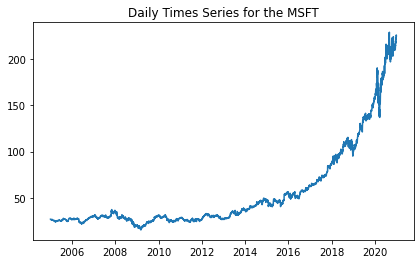

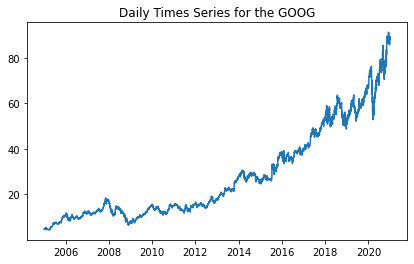

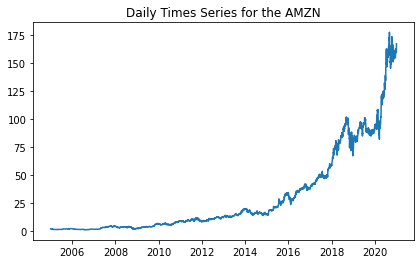

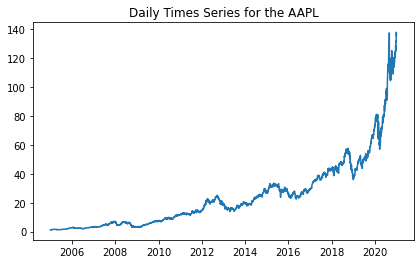

In [ ]:
plt.figure(figsize=(15, 4))
#MSFT
plt.subplot(1, 2, 2)
plt.plot(other_df.index, other_df['MSFT'])
plt.title('Daily Times Series for the MSFT');
plt.figure(figsize=(15, 4))
#GOOG
plt.subplot(1, 2, 2)
plt.plot(other_df.index, other_df['GOOG'])
plt.title('Daily Times Series for the GOOG');
plt.figure(figsize=(15, 4))
#AMZN
plt.subplot(1, 2, 1)
plt.plot(other_df.index, other_df['AMZN'])
plt.title('Daily Times Series for the AMZN')
plt.figure(figsize=(15, 4))
#AAPL
plt.subplot(1, 2, 1)
plt.plot(other_df.index, other_df['AAPL'])
plt.title('Daily Times Series for the AAPL');


In [ ]:
corr_df = other_df.corr(method='pearson')
corr_df.head().reset_index()

,index,AMZN,GOOG,AAPL,MSFT
0,AMZN,1.000000,0.960456,0.962396,0.983188
1,GOOG,0.960456,1.000000,0.942819,0.941771
2,AAPL,0.962396,0.942819,1.000000,0.959586
3,MSFT,0.983188,0.941771,0.959586,1.000000


Thus,MSFT is most corelated to AMZN from the pearson's coefficient